# Lending Club Data Set Prediction

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
from numpy.random import seed
from scipy.stats import norm
from scipy.stats import ttest_ind_from_stats
df= pd.read_csv('/Users/ankit/Desktop/Springboard dox/Python/LoanStats3a_securev1_new.csv',low_memory=False)


# Understanding the various features (columns) of the dataset


In [48]:
print(df.info())
df.head()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42542 entries, 0 to 42541
Columns: 150 entries, id to settlement_term
dtypes: float64(120), object(30)
memory usage: 48.7+ MB
None


Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term'],
      dtype='object', length=150)

In [49]:
print(df.shape)

(42542, 150)


In [50]:
#Drop columns with data NaN

In [51]:
#df=df.dropna(axis=1)

In [52]:
#df.shape

In [53]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,NaN,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,NaN,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


# Data Wrangling

In [54]:
#rename the column names

df = df.rename(columns={"loan_amnt": "loan_amount", "funded_amnt": "funded_amount", "funded_amnt_inv": "investor_funds",
                       "int_rate": "interest_rate", "annual_inc": "annual_income"})


In [55]:
df.head()
print(type(df['interest_rate'][0]))

<class 'str'>


In [56]:
#removing percentage sign from the interest_rate
df.interest_rate = df.interest_rate.str.replace('%', '').astype('float64')
print(df.interest_rate.head())

0    10.65
1    15.27
2    15.96
3    13.49
4    12.69
Name: interest_rate, dtype: float64


In [57]:
#remove months from term colums
df.term = df.term.str.replace('months', '')
df.term.head()

0    36 
1    60 
2    36 
3    36 
4    60 
Name: term, dtype: object

In [58]:
#selecting unique column as index

df['id'].is_unique

False

In [59]:
df.set_index('id')
df.drop(['member_id'],axis=1,inplace=True)

In [60]:
missing_fractions = df.isnull().mean().sort_values(ascending=False)
missing_fractions.head(20)

inq_fi                            1.0
percent_bc_gt_75                  1.0
mths_since_recent_bc_dlq          1.0
mths_since_recent_inq             1.0
mths_since_recent_revol_delinq    1.0
num_accts_ever_120_pd             1.0
num_actv_bc_tl                    1.0
num_actv_rev_tl                   1.0
num_bc_sats                       1.0
num_bc_tl                         1.0
num_il_tl                         1.0
num_op_rev_tl                     1.0
num_rev_accts                     1.0
num_rev_tl_bal_gt_0               1.0
num_sats                          1.0
num_tl_120dpd_2m                  1.0
num_tl_30dpd                      1.0
num_tl_90g_dpd_24m                1.0
num_tl_op_past_12m                1.0
mths_since_recent_bc              1.0
dtype: float64

Text(0, 0.5, 'Feature count')

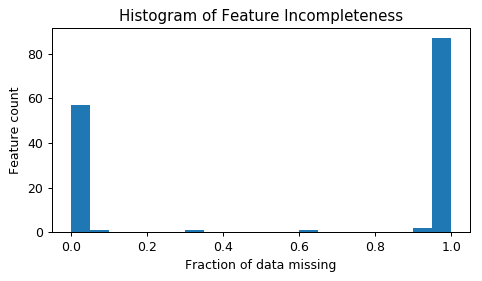

In [61]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

From the above histogram, we see there's a large gap between features missing "some" data (<20%) and those missing "lots" of data (>40%). Because it's generally very difficult to accurately impute data with more than 30% missing values, we drop such columns. First store all variables missing more than 30% data in an alphabetical list:

In [62]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(len(drop_list))
df.drop(labels=drop_list, axis=1, inplace=True)
df.shape

91


(42542, 58)

So now we dropped the columns with more than 30% missing values.

In [63]:
print(df.columns)
df.info()

Index(['id', 'loan_amount', 'funded_amount', 'investor_funds', 'term',
       'interest_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_income', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies',

In [64]:
df['emp_title'].describe()



count       39909
unique      30656
top       US Army
freq          139
Name: emp_title, dtype: object

There are too many different job titles for this feature to be useful, so we drop it.




In [65]:
df.drop(labels='emp_title', axis=1, inplace=True)

In [66]:
df['emp_length'].value_counts(dropna=False).sort_index()

1 year       3595
10+ years    9369
2 years      4743
3 years      4364
4 years      3649
5 years      3458
6 years      2375
7 years      1875
8 years      1592
9 years      1341
< 1 year     5062
NaN          1119
Name: emp_length, dtype: int64

In [67]:
df['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
df['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [68]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
df['emp_length'] = df['emp_length'].apply(emp_length_to_int)
df['emp_length'].value_counts(dropna=False).sort_index()

0.0     5062
1.0     3595
2.0     4743
3.0     4364
4.0     3649
5.0     3458
6.0     2375
7.0     1875
8.0     1592
9.0     1341
10.0    9369
NaN     1119
Name: emp_length, dtype: int64

Annual income ranges from \$0 to \$9,550,000, with a median of \$65,000. Because of the large range of incomes, we should take a log transform of the annual income variable.


In [69]:

df['log_annual_inc'] = df['annual_income'].apply(lambda x: np.log10(x+1))
df['log_annual_inc'].describe()

count    42531.000000
mean         4.764398
std          0.246615
min          3.278067
25%          4.602071
50%          4.770859
75%          4.916459
max          6.778151
Name: log_annual_inc, dtype: float64

In [70]:
df.corr()

,loan_amount,funded_amount,investor_funds,interest_rate,installment,emp_length,annual_income,dti,delinq_2yrs,fico_range_low,...,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,log_annual_inc
loan_amount,1.000000,0.981746,0.929600,0.292346,0.930869,0.158339,0.276122,0.065112,-0.032767,0.133232,...,0.080470,0.073939,NaN,NaN,-0.005777,NaN,-0.003974,-0.037557,-0.005963,0.443773
funded_amount,0.981746,1.000000,0.947527,0.295154,0.956522,0.157903,0.272067,0.064821,-0.033421,0.125637,...,0.080178,0.073785,NaN,NaN,-0.005627,NaN,-0.003938,-0.038855,-0.006001,0.439721
investor_funds,0.929600,0.947527,1.000000,0.279995,0.890151,0.173111,0.252329,0.071073,-0.043868,0.144942,...,0.091407,0.086590,NaN,NaN,-0.012590,NaN,-0.006201,-0.046124,-0.006242,0.413387
interest_rate,0.292346,0.295154,0.279995,1.000000,0.271433,0.000062,0.054365,0.119607,0.154699,-0.702587,...,-0.303422,-0.238442,NaN,NaN,0.003324,NaN,0.002522,0.085286,0.001651,0.075772
installment,0.930869,0.956522,0.890151,0.271433,1.000000,0.128330,0.278339,0.054948,-0.020096,0.064362,...,0.075406,0.069030,NaN,NaN,-0.004109,NaN,-0.003495,-0.033746,-0.005929,0.442504
emp_length,0.158339,0.157903,0.173111,0.000062,0.128330,1.000000,0.115990,0.058428,0.012322,0.089997,...,0.020976,0.024964,NaN,NaN,-0.000483,NaN,-0.004048,0.060733,0.002856,0.213810
annual_income,0.276122,0.272067,0.252329,0.054365,0.278339,0.115990,1.000000,-0.116559,0.022161,0.052027,...,0.064124,0.058180,NaN,NaN,-0.000926,NaN,-0.001809,-0.015437,-0.001828,0.708420
dti,0.065112,0.064821,0.071073,0.119607,0.054948,0.058428,-0.116559,1.000000,-0.036577,-0.191153,...,-0.048400,-0.022551,NaN,NaN,-0.013132,NaN,-0.009262,0.008671,-0.003346,-0.088996
delinq_2yrs,-0.032767,-0.033421,-0.043868,0.154699,-0.020096,0.012322,0.022161,-0.036577,1.000000,-0.218583,...,-0.074326,-0.049844,NaN,NaN,0.072845,NaN,0.121651,0.004708,-0.001452,0.032322
fico_range_low,0.133232,0.125637,0.144942,-0.702587,0.064362,0.089997,0.052027,-0.191153,-0.218583,1.000000,...,0.353463,0.276505,NaN,NaN,-0.013217,NaN,-0.009830,-0.131334,-0.009143,0.083294


In [71]:
df["loan_status"].value_counts()


Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64

In [72]:
# Determining the loans that are bad from loan_status column

bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]


df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
    
df['loan_condition'] = df['loan_status'].apply(loan_condition)

# Pie Chart for Loan Conditions

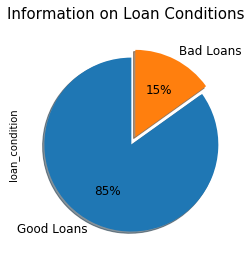

In [73]:
#f, ax = plt.subplots(1,2, figsize=(16,8))

labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=15)

df["loan_condition"].value_counts().plot.pie(explode=[0,0.10],autopct='%1.0f%%', shadow=True,labels=labels, fontsize=12, startangle=90)




In [74]:
df['income_category'] = np.nan
lst = [df]

for col in lst:
    col.loc[col['annual_income'] <= 100000, 'income_category'] = 'Low'
    col.loc[(col['annual_income'] > 100000) & (col['annual_income'] <= 200000), 'income_category'] = 'Medium'
    col.loc[col['annual_income'] > 200000, 'income_category'] = 'High'

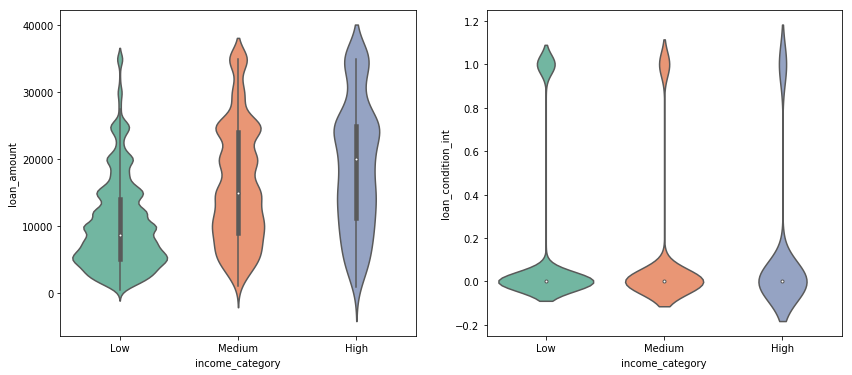

In [75]:
# Let's transform the column loan_condition into integrers.

lst = [df]
df['loan_condition_int'] = np.nan

for col in lst:
    col.loc[df['loan_condition'] == 'Good Loan', 'loan_condition_int'] = 0 # Negative (Bad Loan)
    col.loc[df['loan_condition'] == 'Bad Loan', 'loan_condition_int'] = 1 # Positive (Good Loan)
    
# Convert from float to int the column (This is our label)  
df['loan_condition_int'] = df['loan_condition_int'].astype(int)
fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# Change the Palette types tomorrow!

sns.violinplot(x="income_category", y="loan_amount", data=df, palette="Set2", ax=ax1 )
sns.violinplot(x="income_category", y="loan_condition_int", data=df, palette="Set2", ax=ax2)


In [76]:
#df.corr(loan_status,annual_income)

# Loan Condition V/s Income

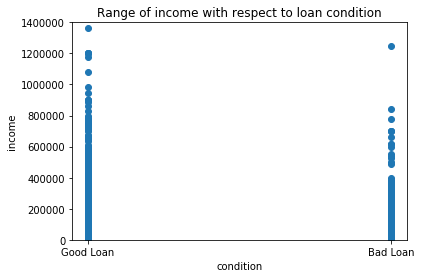

In [77]:
plt.scatter(df.loan_condition,df.annual_income)
plt.xlabel("condition")
plt.ylabel("income")
plt.ylim(0,1400000)
plt.title("Range of income with respect to loan condition")
plt.show()

# Loan Consition V/s Fico Scores

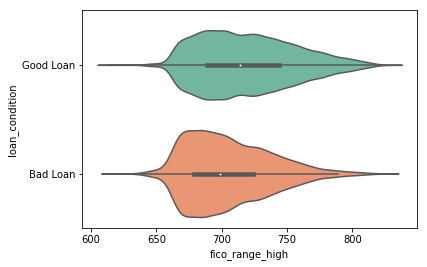

In [78]:
sns.violinplot(x="fico_range_high", y="loan_condition", data=df, palette="Set2" )
plt.show()

The mean of the good loans is more than 700 and most of the values of fico_score lies near 700 score hence the fico score for good loans should be closer to 700.

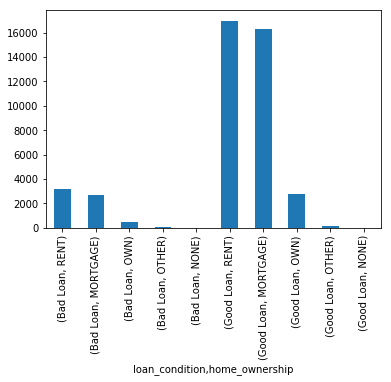

In [79]:
df.home_ownership.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()

Loan Grades and Subgrades are assigned by Lending Club based on the borrower’s credit worthiness and also on some variables specific to that Loan.

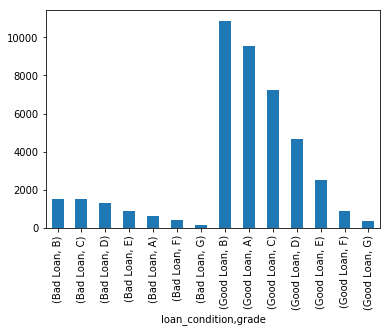

In [80]:
df.grade.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()

The majority of loans is either graded as B or C — together these correspond to more than 50% of the loan population.
While there is a considerable amount of A graded or “prime” loans (~17%), there is a small amount of E graded, or “uncollectible” loans (~0,06%). Which is a good sign for Lending Club.
But, are these the right grades?

# Statistical Inferences of the Dataset

ValueError: cannot convert float NaN to integer

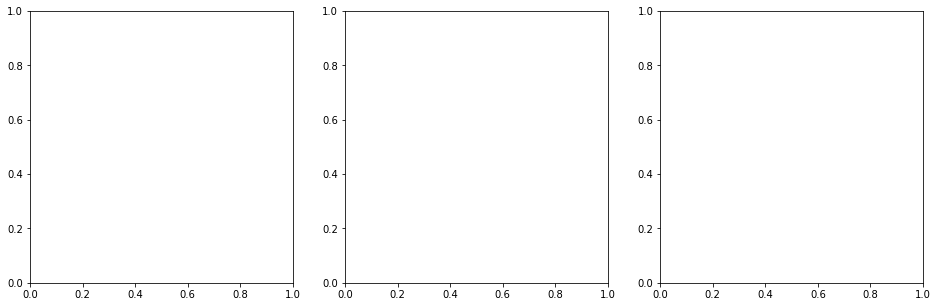

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = df["loan_amount"].values
funded_amount = df["funded_amount"].values
investor_funds = df["investor_funds"].values
sns.distplot(loan_amount, ax=ax[0], color="red")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="blue")
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="green")
ax[2].set_title("Total committed by Investors", fontsize=14)

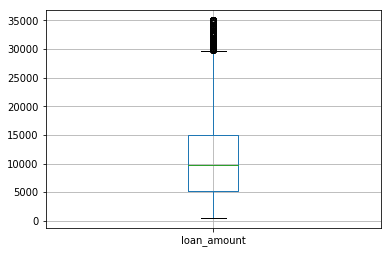

In [82]:
df.boxplot(column='loan_amount')


In [83]:
mean =np.mean(df.funded_amount)
std =np.std(df.funded_amount)
print(mean)
print(std)

10821.585752909368
7146.830662349949


# Null hypothesis: The mean interest rates offered for A grade loans are less than the other grades.

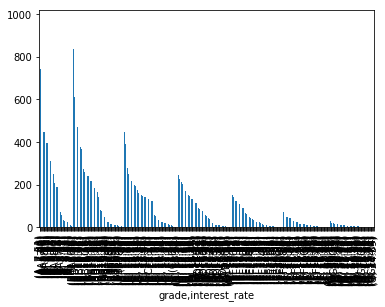

In [84]:
df.interest_rate.groupby(df.grade).value_counts().plot.bar()
plt.show()


ValueError: cannot convert float NaN to integer

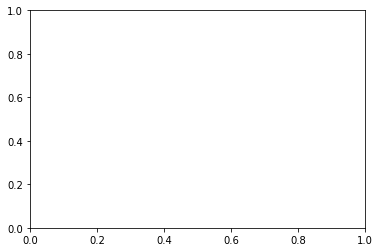

In [85]:
sns.distplot(df.interest_rate[df.grade!='A'].astype('float64').values,color="red")


In [86]:
def loan_sampler_A(n):
    return np.random.choice(df.interest_rate[df.grade=='A'].astype('float64'), n)
def loan_sampler_other(n):
    return np.random.choice(df.interest_rate[df.grade!='A'].astype('float64'),n)

In [87]:
seed(47)
size=50
sample1 = loan_sampler_A(size).astype('float64')
sample2 = loan_sampler_other(size).astype('float64')
print(sample1)
type(sample1[0])

[7.66 6.62 7.14 7.74 5.42 6.99 7.88 8.94 7.49 8.49 7.9  6.54 5.79 7.88
 7.51 7.88 8.   7.14 7.37 8.49 7.66 5.42 7.66 7.49 8.94 9.32 7.29 6.91
 8.9  6.03 7.74 6.17 6.17 7.88 6.91 8.49 6.54 7.66 7.49 8.   5.42 5.42
 7.9  5.42 7.51 7.9  7.75 7.49 7.75 7.12]


numpy.float64

In [88]:
mean_A = np.mean(sample1)
mean_other = np.mean(sample2)
std_A=np.std(sample1)
std_other=np.std(sample2)
seed(47)
N=500
# take your samples here
total_mean_A=np.empty(N)
total_mean_other=np.empty(N)
for i in range (N):
    total_mean_A[i]=np.mean(loan_sampler_A(size))
    total_mean_other[i]=np.mean(loan_sampler_other(size))


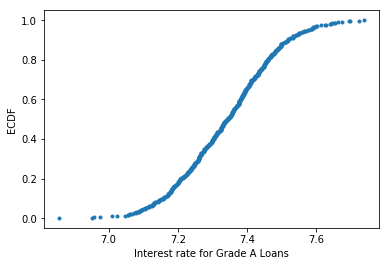

In [89]:
n=len(total_mean_A)
x=np.sort(total_mean_A)
y=np.arange(1,n+1)/n
plt.plot(x,y,marker='.',linestyle='none')
# Label the axes
plt.xlabel('Interest rate for Grade A Loans')
plt.ylabel('ECDF')
plt.show()

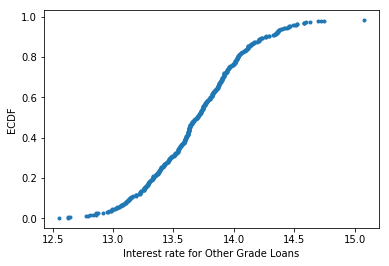

In [90]:
n=len(total_mean_other)
x=np.sort(total_mean_other)
y=np.arange(1,n+1)/n
plt.plot(x,y,marker='.',linestyle='none')
# Label the axes
plt.xlabel('Interest rate for Other Grade Loans')
plt.ylabel('ECDF')
plt.show()

It is very much clear from the above ECDF graph that the interest rates for the other grades lies in the range of (12.5,15)

In [91]:
from scipy import stats
import scipy.stats
print(stats.ttest_ind(total_mean_other,total_mean_A))

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
print("The confidence interval for A grade loans is: "+str(mean_confidence_interval(total_mean_A)))
print("The confidence interval for all other loan other than A grade loans is:"+ str(mean_confidence_interval(total_mean_other)))
           
      

Ttest_indResult(statistic=nan, pvalue=nan)
The confidence interval for A grade loans is: (7.339761200000001, 7.327202348671294, 7.352320051328707)
The confidence interval for all other loan other than A grade loans is:(nan, nan, nan)


Here, the p value is less than 0.05 hence the result is of high significance.

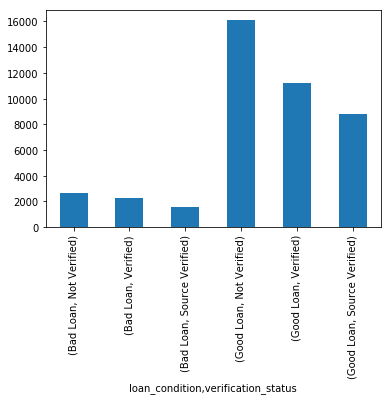

In [92]:
df.verification_status.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()


The observation is quite unexpected as it was expected that people with verified status should have less charged off loans but it is the opposit. Hence,verification status does not give any clear idea of the impact on the loan condition. So we try to see in other way.


In [93]:
pd.crosstab(df ['verification_status'], df ['loan_condition'], margins=True)


loan_condition,Bad Loan,Good Loan,All
verification_status,,,
Not Verified,2655,16103,18758
Source Verified,1534,8772,10306
Verified,2242,11229,13471
All,6431,36104,42535


This shows that 41.3% of the bad loans were not verified.

In [94]:
df[['fico_range_low', 'fico_range_high']].describe()


,fico_range_low,fico_range_high
count,42535.000000,42535.000000
mean,713.052545,717.052545
std,36.188439,36.188439
min,610.000000,614.000000
25%,685.000000,689.000000
50%,710.000000,714.000000
75%,740.000000,744.000000
max,825.000000,829.000000


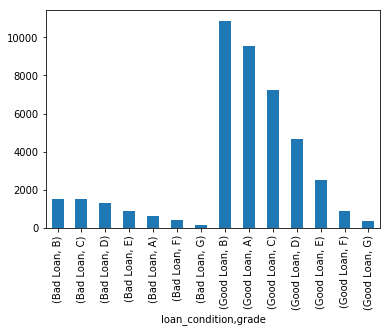

In [95]:
df.grade.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()

Number of bad loans were less in the category A jobs and it had more number of good loans as compared to the other category.

# Correlation among the features

Few important columns are selected from the full dataset based on the significance and the data present prior to the approval of the loan. The columns are saved in 'imp_columns' list.

Now we will see the correlation between the numerical data

In [96]:
imp_columns=['loan_amount','term','interest_rate','grade','emp_length','home_ownership','annual_income','verification_status','loan_status','loan_condition','purpose','title','addr_state','fico_range_low','fico_range_high','income_category']
df2=df[imp_columns]
df2.corr()

,loan_amount,interest_rate,emp_length,annual_income,fico_range_low,fico_range_high
loan_amount,1.000000,0.292346,0.158339,0.276122,0.133232,0.133232
interest_rate,0.292346,1.000000,0.000062,0.054365,-0.702587,-0.702587
emp_length,0.158339,0.000062,1.000000,0.115990,0.089997,0.089997
annual_income,0.276122,0.054365,0.115990,1.000000,0.052027,0.052027
fico_range_low,0.133232,-0.702587,0.089997,0.052027,1.000000,1.000000
fico_range_high,0.133232,-0.702587,0.089997,0.052027,1.000000,1.000000


employee length,annual income and fico scores have strong positive correlation with the loan amount .

In [97]:
df[imp_columns].head()

,loan_amount,term,interest_rate,grade,emp_length,home_ownership,annual_income,verification_status,loan_status,loan_condition,purpose,title,addr_state,fico_range_low,fico_range_high,income_category
0,5000.0,36,10.65,B,10.0,RENT,24000.0,Verified,Fully Paid,Good Loan,credit_card,Computer,AZ,735.0,739.0,Low
1,2500.0,60,15.27,C,0.0,RENT,30000.0,Source Verified,Charged Off,Bad Loan,car,bike,GA,740.0,744.0,Low
2,2400.0,36,15.96,C,10.0,RENT,12252.0,Not Verified,Fully Paid,Good Loan,small_business,real estate business,IL,735.0,739.0,Low
3,10000.0,36,13.49,C,10.0,RENT,49200.0,Source Verified,Fully Paid,Good Loan,other,personel,CA,690.0,694.0,Low
4,3000.0,60,12.69,B,1.0,RENT,80000.0,Source Verified,Fully Paid,Good Loan,other,Personal,OR,695.0,699.0,Low


Correlation between all the important columns:

In [98]:
df2.apply(lambda x: x.factorize()[0]).corr()
corr_imp=df2.apply(lambda x: x.factorize()[0]).corr()


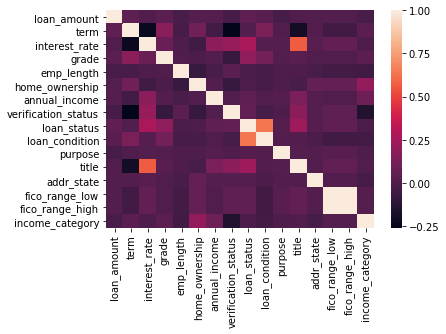

In [99]:
import seaborn as sns

sns.heatmap(corr_imp, 
        xticklabels=corr_imp.columns,
        yticklabels=corr_imp.columns)

# Data Preparation for Model Building

In [100]:
# Convert all non-numeric values to number
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
for var in df.columns:
    le = LabelEncoder()
    df[var]=df[var].astype('str')
    df[var]=le.fit_transform(df[var])
df[imp_columns].dtypes


loan_amount            int64
term                   int64
interest_rate          int64
grade                  int64
emp_length             int64
home_ownership         int64
annual_income          int64
verification_status    int64
loan_status            int64
loan_condition         int64
purpose                int64
title                  int64
addr_state             int64
fico_range_low         int64
fico_range_high        int64
income_category        int64
dtype: object

# Model building

In [101]:
from sklearn import preprocessing
target_name='loan_condition'
y= df.loan_condition
X= df.drop(target_name,axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123)
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

In [102]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [103]:
y_predict=knn.predict(X_test)
#y_predict=y_predict.reshape(-1,1)

In [114]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))

Accuracy: 0.9310831139526138


We got an accuracy of 0.93 . As our model has good loans dominating the sample we may need to over sample our data with bad sample.

We would now check the effect on the accuracy by changing n in the model and the graph is plotted below:

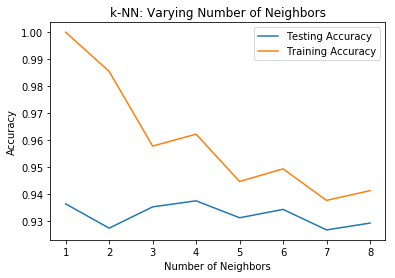

In [112]:
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
from sklearn.neighbors import KNeighborsClassifier
# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


From the above graph we can see that we get best result at n= 4 which gives us training accuracy as 0.96 and testing accuracy as 0.94

# Confusion Matrix

In [115]:
#Random Forest
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10000, random_state = 42)
rf.fit(X_train, y_train);
predictions = rf.predict(X_test)
cm = confusion_matrix(y_test,predictions)
print(cm)

#Decision Tree

from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
cm2 = confusion_matrix(y_test,predictions)
print(cm2)

[[1608    0]
 [   0 9028]]
[[1608    0]
 [   0 9028]]


Imbalanced datasets can be seen everywhere. Usually banks want to predict fraudulent credit card charges but only a small fraction of observations are actually positives. I’d guess that only 1 in 10,000 credit card charges are fraudulent, at most. Recently, oversampling the minority class observations has become a common approach to improve the quality of predictive modeling. By oversampling, models are sometimes better able to learn patterns that differentiate classes.

In [1131]:
!pip install imblearn


    100% |████████████████████████████████| 174kB 3.3MB/s ta 0:00:01
    100% |████████████████████████████████| 10.5MB 1.0MB/s ta 0:00:01
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3


In [116]:
from imblearn.over_sampling import SMOTE


In [117]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print y_train.value_counts(), np.bincount(y_res)


In [119]:
x_train_res

array([[18463,   379,   446, ...,  4955,     2,     0],
       [25199,   834,   983, ...,  2021,     1,     0],
       [ 7970,    84,    89, ...,  4286,     1,     0],
       ...,
       [25073,   304,   354, ...,  1543,     1,     1],
       [ 6383,   407,   487, ...,  1526,     1,     1],
       [12079,   319,   365, ...,  3444,     1,     1]])

In [128]:
from sklearn.metrics import recall_score

clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(x_train_res, y_train_res)
print('Validation Results')
print(clf_rf.score(X_test, y_test))
print(recall_score(y_test, clf_rf.predict(X_test)))
print(clf_rf.score(test_features, test_target))
print(recall_score(test_target, clf_rf.predict(test_features)))

Validation Results
1.0
1.0


NameError: name 'test_features' is not defined